<a href="https://colab.research.google.com/github/neerajthandayan/Deep_Learning/blob/main/DataAnalysis/DataAnalysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
#!pip install -U imbalanced-learn

In [2]:
import imblearn
print("Imbalanced-Learn", imblearn.__version__)

Imbalanced-Learn 0.8.0


In [3]:
# Wrangling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Analysis
import statsmodels.api as sm
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import SMOTE, RandomOverSampler, SVMSMOTE, ADASYN, KMeansSMOTE, SMOTENC, SMOTEN

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_json('/content/drive/MyDrive/EssexDissertation/ProcessedFiles/NewPrepedData.json')
data.head()

,id,username,tweet,hashtags,mentions,retweets,likes,caucus,mention_check,cleaned_tweet,pop_score,sentiment,emotion
0,1358846364365553664,william_wragg,So far we have said the NHS will contact you f...,[covid19],[],10,11,Gov,0,letter england live try contact vaccine appoin...,-0.154457,NEU,others
1,1262643695490420736,william_wragg,The symptoms to look out for with #Coronavirus...,"[coronavirus, stayalert]",[],3,8,Gov,0,symptom experience high new temperature contin...,-0.160708,NEU,fear
2,1241445566577553408,william_wragg,NEW GOVERNMENT LANDING PAGE FOR ALL CORONAVIRU...,"[coronavirus, coronavirusuk, covid19, staysafe...",[],3,6,Gov,0,business new landing health employee governmen...,-0.161958,NEU,others
3,1242208854286503936,scrabbpembs,Strange and difficult times for our country. W...,[covid19],[],4,23,Gov,0,time absolutely strange real home message poli...,-0.150707,NEU,fear
4,1242124443268386816,scrabbpembs,We can’t have a repeat of what we saw at the w...,[covid19],"[{'screen_name': 'fmwales', 'name': 'mark drak...",1,6,Gov,0,large today parks flock village weekend step w...,-0.163208,NEU,fear


## Mentions

In [5]:
mention = []
twtr = []

for i in range(len(data)):
  un = []
  for x in range(len(data['mentions'][i])):
    un.append(data['mentions'][i][x]['screen_name'])
    for y in list(set(un)):
      mention.append(y)
      twtr.append(data['caucus'][i])

mn_df = pd.DataFrame({'Caucus': twtr,
                      'mention': mention}).reset_index(drop=True)

In [6]:
mn_df.head()

,Caucus,mention
0,Gov,fmwales
1,Gov,fmwales
2,Gov,simonhartmp
3,Gov,h_s_e
4,Gov,nfusussexsurrey


In [7]:
def mention_plot(x,color,title):
  fig, ax = plt.subplots(figsize=(10,6))
  ax.barh(range(len(x)),x['mention'],color=color)
  ax.set_yticks(range(len(x)), minor=False)
  ax.set_yticklabels(x['index'], minor=False)
  ax.set_xlabel("Counts")
  ax.set_ylabel("Mentions")
  ax.set_title(title)

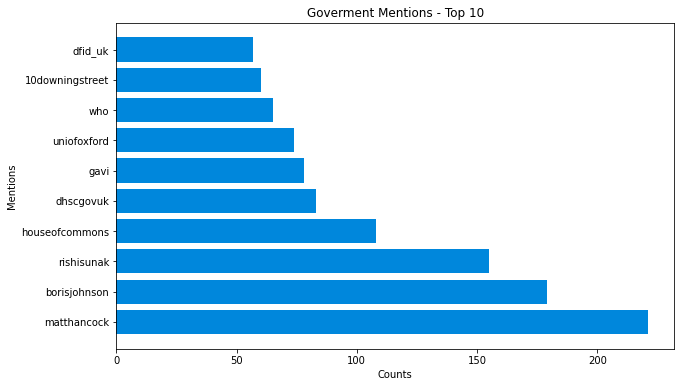

In [8]:
# Governemnt Most Mentions

mention_plot(mn_df['mention'].loc[mn_df['Caucus'] == 'Gov'].value_counts().head(10).reset_index(drop=False),
             '#0087DC',
             'Goverment Mentions - Top 10')

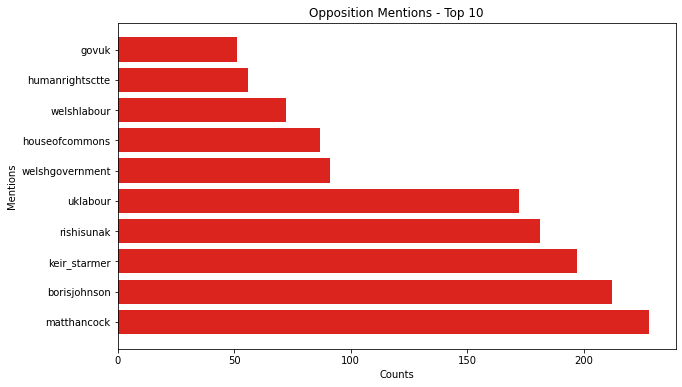

In [9]:
# Opposition Most Mentions

mention_plot(mn_df['mention'].loc[mn_df['Caucus'] == 'Opp'].value_counts().head(10).reset_index(drop=False),
             '#DC241f',
             'Opposition Mentions - Top 10')

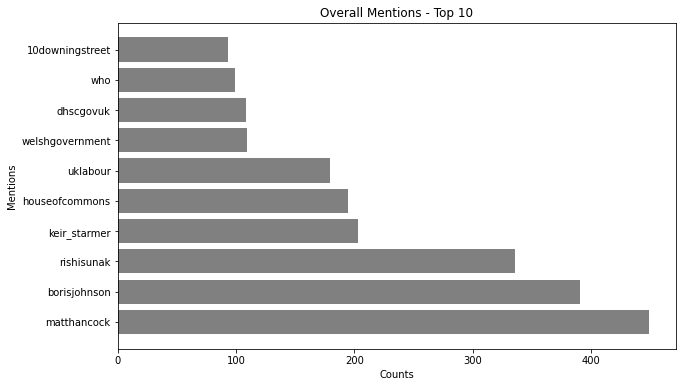

In [10]:
# Overall Most Mentions

mention_plot(mn_df['mention'].value_counts().head(10).reset_index(drop=False),
             'grey',
             'Overall Mentions - Top 10')

## Sentiment

#### Visualization

In [11]:
# Creating Sentiment DataFrame
sent = data[['caucus','sentiment','pop_score']]
sent.head()

,caucus,sentiment,pop_score
0,Gov,NEU,-0.154457
1,Gov,NEU,-0.160708
2,Gov,NEU,-0.161958
3,Gov,NEU,-0.150707
4,Gov,NEU,-0.163208


In [12]:
# Function for Plotting

def sent_plot(data,title,color):
  fig, ax = plt.subplots(figsize=(10,6))
  ax.bar(data['index'],data['sentiment'], color=color)
  ax.set_xticks(range(len(data['sentiment'].unique())), minor=False)
  ax.set_xticklabels(data['index'].unique(), minor=False)
  ax.set_xlabel("Sentiment")
  ax.set_ylabel("Frequency")
  ax.set_title(title)

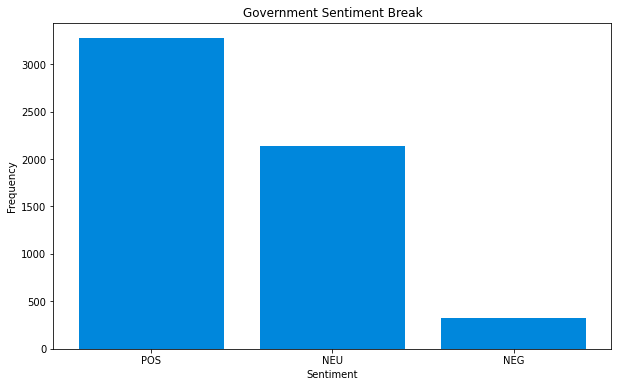

In [13]:
# Government Sentiment Break Up
sent_plot(sent['sentiment'].loc[sent['caucus'] == 'Gov'].value_counts().to_frame().reset_index(drop=False), 
          'Government Sentiment Break',
          '#0087DC')

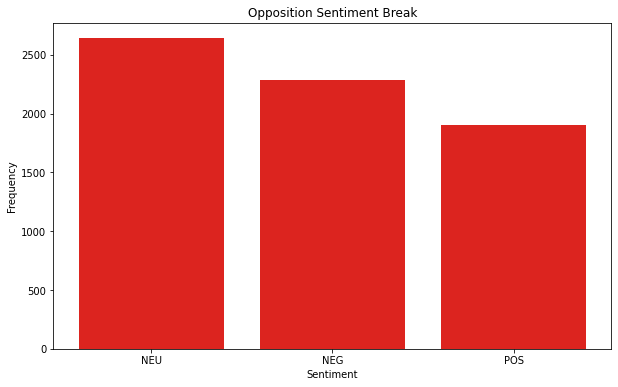

In [14]:
# Oppsition Sentiment Break Up
sent_plot(sent['sentiment'].loc[sent['caucus'] == 'Opp'].value_counts().to_frame().reset_index(drop=False), 
          'Opposition Sentiment Break',
          '#DC241f')

Text(0.5, 1.0, 'Overall Sentiment Breakup')

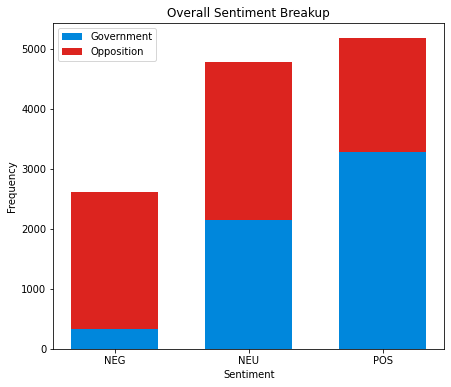

In [15]:
# Overall Sentiment Break Up

sen_gov = sent['sentiment'].loc[sent['caucus'] == 'Gov'].value_counts().to_frame().reset_index(drop=False).sort_values(by='index')
sen_opp = sent['sentiment'].loc[sent['caucus'] == 'Opp'].value_counts().to_frame().reset_index(drop=False).sort_values(by='index')

fig1, ax1 = plt.subplots(figsize=(7,6))
ax1.bar(sen_gov['index'],sen_gov['sentiment'],0.65,color='#0087DC', label="Government")
ax1.bar(sen_opp['index'],sen_opp['sentiment'],0.65,color='#DC241f',bottom=sen_gov['sentiment'], label='Opposition')
ax1.legend(loc='upper left')
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Frequency")
ax1.set_title("Overall Sentiment Breakup")

#### Analysis

In [16]:
def sent_ols(X,y,sampler=None):
  if sampler != None:
    sampler = sampler
    y_res, X_res = sampler.fit_resample(y.values.reshape(-1,1), X)
    sent_res = pd.DataFrame({'sentiment':X_res,
                            'pop_score':y_res.reshape(1,len(y_res))[0]})
  else:
    sent_res = pd.DataFrame({'sentiment':X,
                             'pop_score':y})

  # Overall OLS Model 
  sent_logit = sm.OLS(sent_res['pop_score'],
                      pd.get_dummies(sent_res['sentiment']))
  result = sent_logit.fit()
  return  print(result.summary())

In [26]:
# OLS Model for Overall Correlation
sent_ols(sent.iloc[:,1],
         sent.iloc[:,-1],
         AllKNN())

                            OLS Regression Results                            
Dep. Variable:              pop_score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.17
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           1.96e-06
Time:                        16:36:32   Log-Likelihood:                -11153.
No. Observations:                6952   AIC:                         2.231e+04
Df Residuals:                    6949   BIC:                         2.233e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NEG            0.0999      0.024      4.238      0.0

In [18]:
# OLS Model for Gov Tweet Correlation

sent_ols(sent['sentiment'].loc[sent['caucus'] == 'Gov'],
         sent['pop_score'].loc[sent['caucus'] == 'Gov'],
         SMOTEN())

                            OLS Regression Results                            
Dep. Variable:              pop_score   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     42.36
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           4.83e-19
Time:                        16:31:54   Log-Likelihood:                -13508.
No. Observations:                9819   AIC:                         2.702e+04
Df Residuals:                    9816   BIC:                         2.704e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NEG           -0.1274      0.017     -7.611      0.0

In [19]:
# OLS Model for Gov Tweet Correlation

sent_ols(sent['sentiment'].loc[sent['caucus'] == 'Opp'],
         sent['pop_score'].loc[sent['caucus'] == 'Opp'],
         SMOTEN())

                            OLS Regression Results                            
Dep. Variable:              pop_score   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     62.11
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           1.71e-27
Time:                        16:31:55   Log-Likelihood:                -8014.4
No. Observations:                7923   AIC:                         1.603e+04
Df Residuals:                    7920   BIC:                         1.606e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
NEG            0.0824      0.013      6.363      0.0

## Emotion

#### Visualisation

In [28]:
# Creating Emotion DataFrame
emo = data[['caucus','emotion','pop_score']]
emo.head()

,caucus,emotion,pop_score
0,Gov,others,-0.154457
1,Gov,fear,-0.160708
2,Gov,others,-0.161958
3,Gov,fear,-0.150707
4,Gov,fear,-0.163208


In [29]:
# Function for Plotting

def emo_plot(data,title,color):
  fig, ax = plt.subplots(figsize=(10,6))
  ax.bar(data['index'],data['emotion'], color=color)
  ax.set_xticks(range(len(data['emotion'].unique())), minor=False)
  ax.set_xticklabels(data['index'].unique(), minor=False)
  ax.set_xlabel("Emotion")
  ax.set_ylabel("Frequency")
  ax.set_title(title)

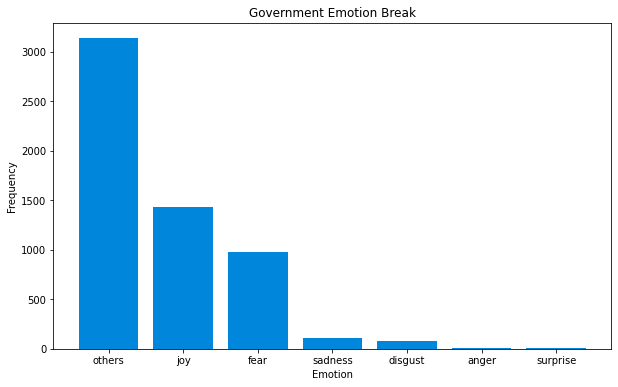

In [30]:
# Government Sentiment Break Up
emo_plot(emo['emotion'].loc[emo['caucus'] == 'Gov'].value_counts().to_frame().reset_index(drop=False), 
         'Government Emotion Break',
         '#0087DC')

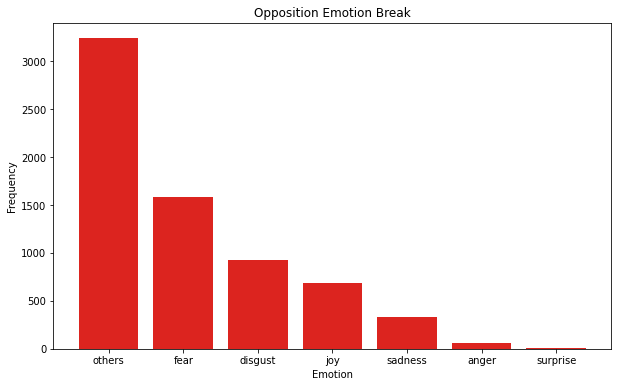

In [33]:
# Opposition Sentiment Break Up
emo_plot(emo['emotion'].loc[emo['caucus'] == 'Opp'].value_counts().to_frame().reset_index(drop=False), 
         'Opposition Emotion Break',
         '#DC241f')

Text(0.5, 1.0, 'Overall Emotion Breakup')

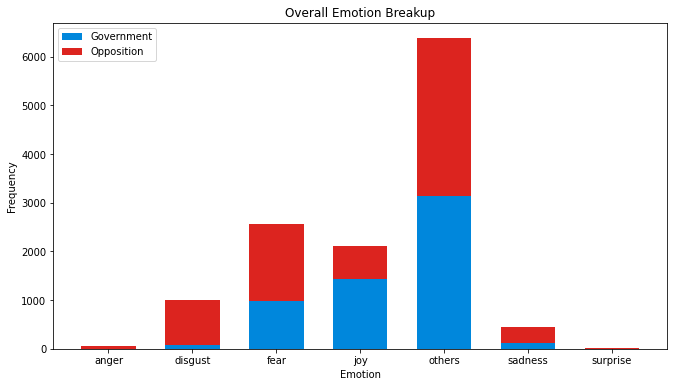

In [34]:
# Overall Emotion Break Up

emo_gov = emo['emotion'].loc[emo['caucus'] == 'Gov'].value_counts().to_frame().reset_index(drop=False).sort_values(by='index')
emo_opp = emo['emotion'].loc[emo['caucus'] == 'Opp'].value_counts().to_frame().reset_index(drop=False).sort_values(by='index')

fig1, ax1 = plt.subplots(figsize=(11,6))
ax1.bar(emo_gov['index'],emo_gov['emotion'],0.65,color='#0087DC', label="Government")
ax1.bar(emo_opp['index'],emo_opp['emotion'],0.65,color='#DC241f',bottom=emo_gov['emotion'], label='Opposition')
ax1.legend(loc='upper left')
ax1.set_xlabel("Emotion")
ax1.set_ylabel("Frequency")
ax1.set_title("Overall Emotion Breakup")

#### Analysis

In [35]:
def emo_ols(X,y,sampler=None):
  if sampler != None:
    sampler = sampler
    y_res, X_res = sampler.fit_resample(y.values.reshape(-1,1), X)
    emo_res = pd.DataFrame({'emotion':X_res,
                            'pop_score':y_res.reshape(1,len(y_res))[0]})
  else:
    emo_res = pd.DataFrame({'emotion':X,
                             'pop_score':y})

  # Overall OLS Model 
  sent_logit = sm.OLS(emo_res['pop_score'],
                      pd.get_dummies(emo_res['emotion']))
  result = sent_logit.fit()
  return  print(result.summary())

In [39]:
# Overall Emotion OLS Modle
emo_ols(emo.iloc[:,1],
        emo.iloc[:,-1],
        SMOTE())

                            OLS Regression Results                            
Dep. Variable:              pop_score   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     210.2
Date:                Mon, 23 Aug 2021   Prob (F-statistic):          1.82e-265
Time:                        16:41:44   Log-Likelihood:                -65287.
No. Observations:               44646   AIC:                         1.306e+05
Df Residuals:                   44639   BIC:                         1.306e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
anger          0.4067      0.013     31.102      0.0

In [51]:
# Government Emotion OLS Model

emo_ols(emo['emotion'].loc[emo['caucus'] == 'Gov'],
        emo['pop_score'].loc[emo['caucus'] == 'Gov'],
        RandomOverSampler())

                            OLS Regression Results                            
Dep. Variable:              pop_score   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     40.68
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           1.45e-49
Time:                        16:45:53   Log-Likelihood:                -29880.
No. Observations:               21966   AIC:                         5.977e+04
Df Residuals:                   21959   BIC:                         5.983e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
anger         -0.1379      0.017     -8.192      0.0

In [52]:
# Government Emotion OLS Model

emo_ols(emo['emotion'].loc[emo['caucus'] == 'Opp'],
        emo['pop_score'].loc[emo['caucus'] == 'Opp'],
        RandomOverSampler())

                            OLS Regression Results                            
Dep. Variable:              pop_score   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     235.6
Date:                Mon, 23 Aug 2021   Prob (F-statistic):          3.58e-293
Time:                        16:46:18   Log-Likelihood:                -33391.
No. Observations:               22680   AIC:                         6.680e+04
Df Residuals:                   22673   BIC:                         6.685e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
anger          0.6769      0.019     36.521      0.0